In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4


In [2]:
datasetName="/stor/public/hcad/heart_heart_HCLFetalHeart1/heart_heart_HCLFetalHeart1"

In [3]:
# scRNA
raw_data <- read.csv(paste0(datasetName, "_expression.tsv.gz"),header = TRUE, sep='\t',row.names = 1)

In [4]:
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)

# analysis

In [5]:
# build object
dataobj <- CreateSeuratObject(counts = raw_data, project = "HCAd",meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [6]:
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Centering and scaling data matrix


In [7]:
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))

PC_ 1 
Positive:  MYL7, MYL2, MT-CO1, MT-ND4, ACTC1, MT-CO2, TPM1, SLC25A4, MT-RNR2, MDH1 
	   TNNI3, TNNT2, NPPA, MT-CYB, MYL3, CSRP3, TNNC1, MT-ATP6, MT-CO3, MTATP6P1 
	   FABP3, TNNI1, MT-ND1, MYL9, CKM, MYH7, HSPB1, COX7B, ALDOA, ACTN2 
Negative:  TMSB4X, ACTB, TMSB10, VIM, ACTG1, CALM1, RAMP2, COL4A1, HSPG2, PTMA 
	   ANXA2, A2M, PECAM1, RNASE1, SPARC, ESAM, CDH5, B2M, TM4SF1, FABP4 
	   EEF1A1, IFITM3, TMSB4XP4, CD93, COL4A2, APLNR, IL32, EGFL7, PLVAP, TPT1 
PC_ 2 
Positive:  TMSB10, A2M, MT-CO1, TMSB4X, CDH5, CAV1, FABP4, MT-ND4, CD93, PECAM1 
	   COL4A1, CALM1, CLDN5, MT-CO2, MYL7, ESAM, APLNR, CRIP2, HSPG2, MT-CO3 
	   MYL2, GMFG, MT-ATP6, TNNT3, TM4SF18, MT-RNR2, MT-ND1, KDR, ACTC1, FABP5 
Negative:  COL1A1, COL1A2, DCN, COL3A1, LUM, C7, MGP, MFAP4, COL6A3, MFAP2 
	   GPC3, OGN, MEST, ELN, SPARC, PCOLCE, SERPINE2, PDLIM3, ASPN, FBLN1 
	   ACTA2, FN1, COL5A2, CST3, POSTN, COL5A1, MATN2, COL9A1, TAGLN, DLK1 
PC_ 3 
Positive:  NUSAP1, H2AFZ, UBE2C, CCNB1, KPNA2, TOP2A, TUBA1B, P

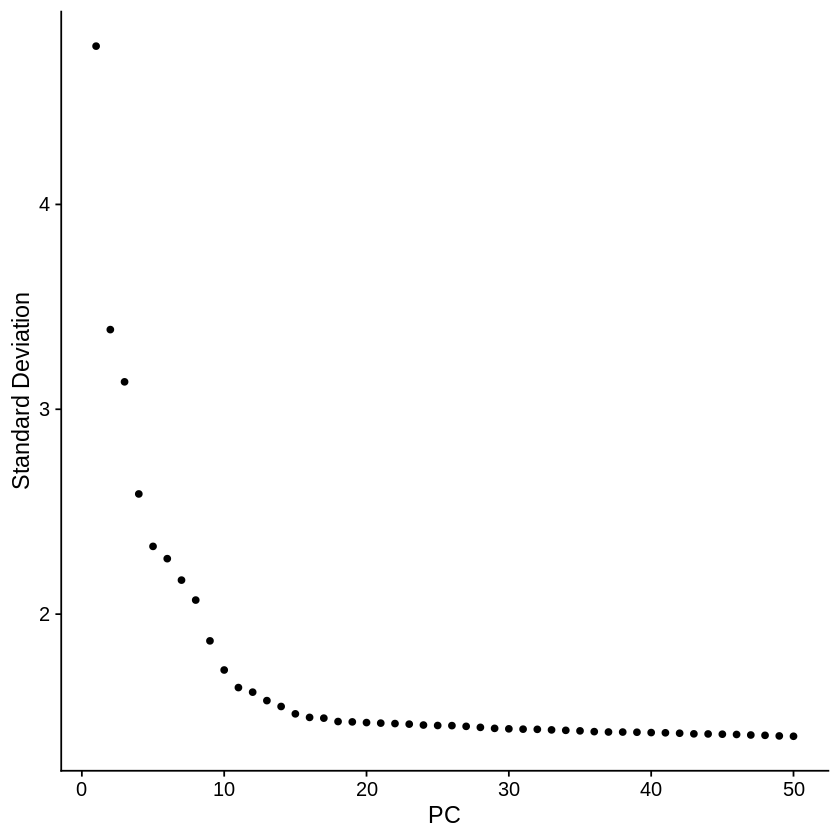

In [8]:
ElbowPlot(dataobj,50) 

In [9]:
pcDim = 30
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”10:44:48 UMAP embedding parameters a = 0.9922 b = 1.112
10:44:48 Read 5319 rows and found 30 numeric columns
10:44:48 Using Annoy for neighbor search, n_neighbors = 30
10:44:48 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
10:44:50 Writing NN index file to temp file /tmp/RtmpQ5VETx/file35284d988907
10:44:50 Searching Annoy index using 1 thread, search_k = 3000
10:44:51 Annoy recall = 100%
10:44:52 Commencing smooth kNN distance calibration using 1 thread
10:44:52 Initializing from normalized Laplacian + noise
10:44:52 Commencing optimizatio

In [10]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

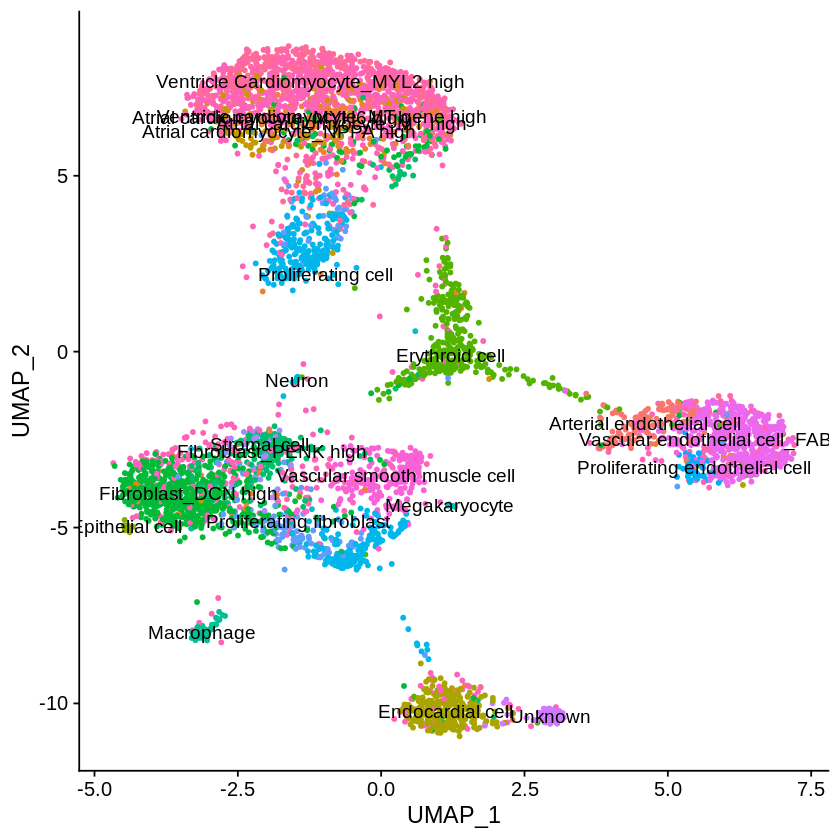

In [11]:
p_umap2

# Clustering

In [12]:
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph
Computing SNN


In [64]:
dataobj <- FindClusters(dataobj, resolution = 2.5, n.start = 10)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5319
Number of edges: 262109

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6253
Number of communities: 20
Elapsed time: 0 seconds


In [65]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

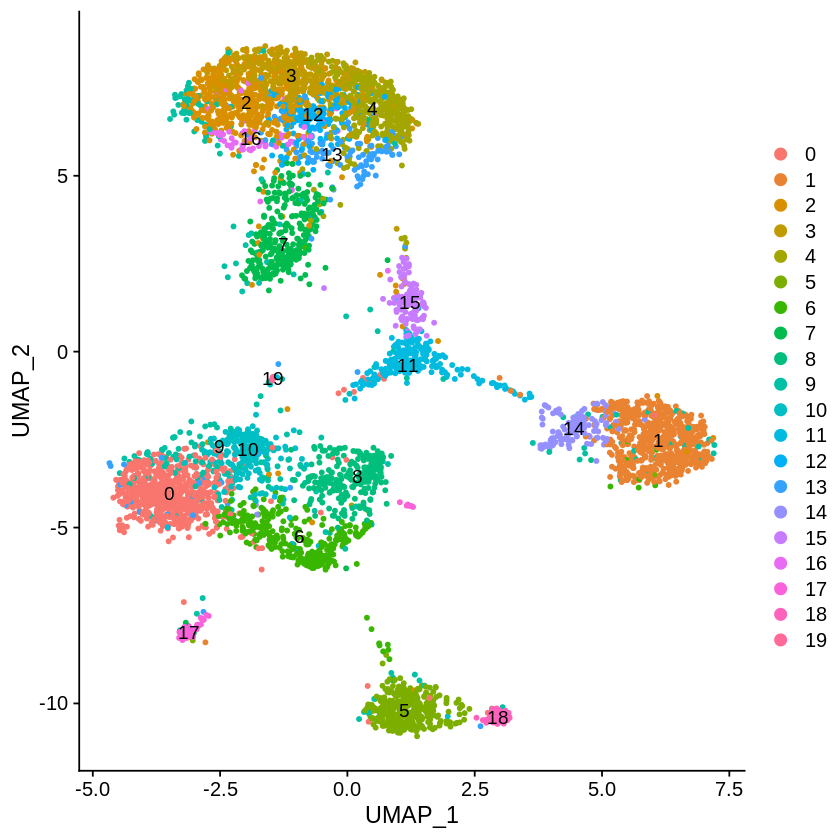

In [66]:
p_umap

# Finding cluster markers 

In [67]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13
Calculating cluster 14
Calculating cluster 15
Calculating cluster 16
Calculating cluster 17
Calculating cluster 18
Calculating cluster 19


# Annatation

In [3]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))

In [89]:
dataobj.markers[dataobj.markers['cluster']==18,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
KISS1,1.868169e-282,1.825998,0.357,0.002,4.112215e-278,18,KISS1
DKK2,1.945946e-256,2.250539,0.536,0.008,4.283416e-252,18,DKK2
IGFL2,1.695579e-243,1.757392,0.268,0.001,3.732309e-239,18,IGFL2
NDP,2.589627e-243,1.613622,0.268,0.001,5.700288e-239,18,NDP
PTHLH,1.835167e-228,1.860460,0.321,0.002,4.039570e-224,18,PTHLH
IFI27,5.245354e-175,2.611707,0.679,0.024,1.154607e-170,18,IFI27
SELL,3.048536e-153,2.611545,0.393,0.008,6.710438e-149,18,SELL
PLCD1,5.527501e-116,1.584830,0.304,0.006,1.216713e-111,18,PLCD1
TFPI2,5.022513e-64,1.552688,0.268,0.010,1.105555e-59,18,TFPI2


In [70]:
dataobj.markers[dataobj.markers['gene']=="GNG11",]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
GNG11,8.588267e-117,1.0991941,0.647,0.226,1.890449e-112,1,GNG11
GNG111,4.591727e-21,0.8891504,0.645,0.268,1.010731e-16,14,GNG11
GNG112,7.955023e-09,0.8562006,0.607,0.273,1.751060e-04,18,GNG11


In [4]:
new.cluster.ids <- c('Heart-Connective Tissue-Fibrocyte-DCN LUM',
                     'Heart-Epithelial Tissue-Vascular endothelial cell-TMSB4X FABP4',                     
                     'Heart-Musle Tissue-Cardiomyocyte Cell-PLN FHL2',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MYL2 MYL7',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MT-ND4 MT-CO2',
                     'Heart-Epithelial Tissue-Endocardial cell-POSTN CDH11',
                     'Heart-Connective Tissue-Fibrocyte-H2AFZ NUSAP1',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-UBE2T NUSAP1',                     
                     'Heart-Musle Tissue-Smooth muscle cell-ACTA2 ACTG2',
                     'Heart-Connective Tissue-Fibrocyte-RPL34 RPL7',
                     'Heart-Connective Tissue-Fibrocyte-SLN COL1A1',
                     'Heart-Connective Tissue-Erythrocyte-HBA1 HBG2',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MT-CO2 MT-ATP6',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MT-RNR2 MT-CYB',
                     'Heart-Epithelial Tissue-Pericyte-CLDN5 CXCR4',                     
                     'Heart-Connective Tissue-Erythrocyte-HBA1 HBG2',
                     'Heart-Musle Tissue-Cardiomyocyte Cell-MYH6 NPPA',
                     'Heart-Connective Tissue-Macrophage-HLA-DRA LCP1',
                     'Unknown',
                     'Heart-Nerve Tissue-Neuron-STMN2 RTN1')
                     


In [5]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
plot <- DimPlot(dataobj, reduction = "umap",label = TRUE, pt.size = 1) + NoLegend()

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

In [6]:
dataobj@meta.data$hcad.label <- Idents(dataobj)

In [7]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [8]:
df_hca <- data.frame(rownames(dataobj@meta.data),dataobj@meta.data$hcad.label)
colnames(df_hca) <- c('cell_ID', 'cell_cluster')

In [9]:
write.table(df_hca, file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)

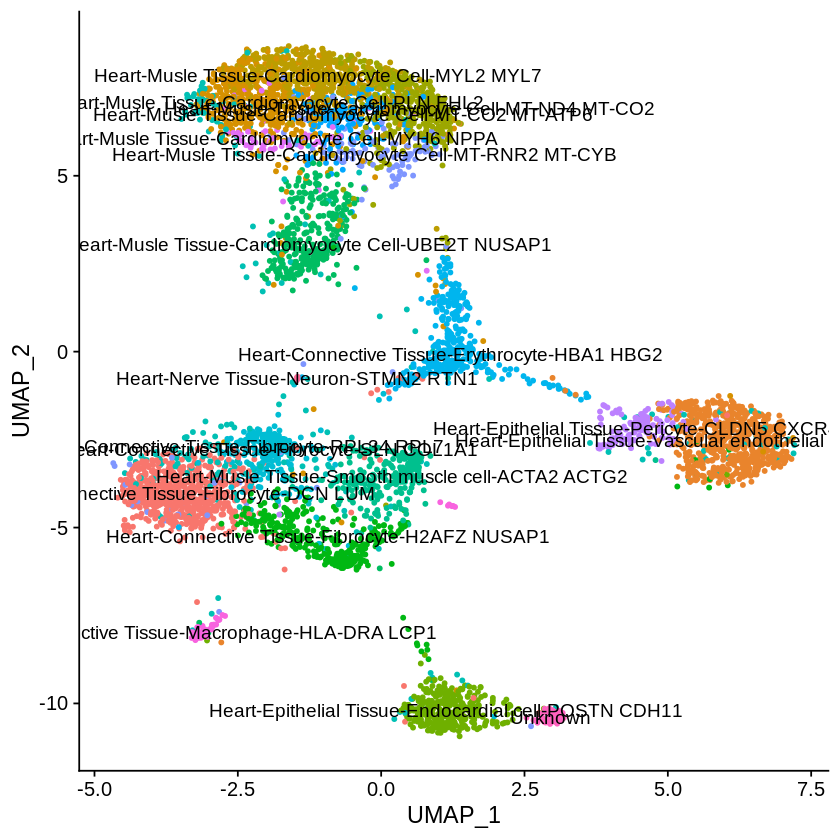

In [93]:
plot

In [94]:
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = plot, width = 8, height = 5)